In [86]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt       # Standard plotting library                 
from IPython.display import display   # A notebook function to display more complex data (like tables)
import scipy.stats as stats           # Scipy again
from math import *

In [78]:
#read an csv file 
df = pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\AdSmart\AdSmartABdata.csv')
df.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
5,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,2020-07-03,15,Samsung SM-G960F,6,Facebook,0,0
6,002e308b-1a07-49d6-8560-0fbcdcd71e4b,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
7,00393fb9-ca32-40c0-bfcb-1bd83f319820,control,2020-07-09,5,Samsung SM-G973F,6,Facebook,0,0
8,004940f5-c642-417a-8fd2-c8e5d989f358,exposed,2020-07-04,0,Generic Smartphone,6,Chrome Mobile WebView,0,0
9,004c4cc9-f2ca-4df7-adc9-3d0c3c4f0342,control,2020-07-05,14,Generic Smartphone,6,Chrome Mobile,0,0


In [79]:
exposed = df.loc[df.experiment == 'exposed']  #exposed set
exposed   
exposed['dateHour'] = pd.to_datetime(exposed.date)

<ipython-input-79-27c07f4596f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposed['dateHour'] = pd.to_datetime(exposed.date)


In [87]:
#Selecting Feature : Here, you need to divide the given columns into two types of variables dependent(or target variable)
#and independent variable(or feature variables).
'''
  segment data into exposed and control groups
  consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
  create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
  '''
def transform_data(df):
    # split dataset to control and exposed groups (feature variables)
    exposed = df.loc[df.experiment == 'exposed']  #exposed set
    control = df.loc[df.experiment == 'control']  #control set

         # creat new column datehour for exposed group
    exposed['date_hour'] = pd.to_datetime(exposed.date) 
    exposed.date_hour += pd.to_timedelta(exposed.hour, unit='h')
    exposed.date_hour = exposed.date_hour.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
          # creat new column datehour for control group
    control['date_hour'] = pd.to_datetime(control.date)
    control.date_hour += pd.to_timedelta(control.hour, unit='h')
    control.date_hour = control.date_hour.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))

           # groupby df using date_hour and count
    df_exposed = exposed.groupby('date_hour').agg({'auction_id':'count', 'device_make':'count', 'platform_os':'count', 'browser':'count', 'yes':'sum', 'no':'sum'})
    df_control = control.groupby('date_hour').agg({'auction_id':'count', 'device_make':'count', 'platform_os':'count', 'browser':'count', 'yes':'sum', 'no':'sum'})

          # creat an array engagement for each group (sum number of yes and no)
    df_exposed['engagement'] = df_exposed['yes'] + df_exposed['no']
    df_control['engagement'] = df_control['yes'] + df_control['no']

         # create an array success using yes
    df_exposed['success'] = df_exposed['yes'] 
    df_control['success'] = df_control['yes'] 

         # probablity of success
    global  prob_succ_exp, prob_succ_con
    prob_succ_exp = sum(df_exposed['success']) / sum(df_exposed['engagement'])
    prob_succ_con = sum(df_control['success']) / sum(df_control['engagement'])
     # Convert the DataFrame to a NumPy array
    engag_exp = df_exposed['engagement'].to_numpy()
    engag_con = df_control['engagement'].to_numpy()


           # Generates a random sample from a given 1-D array
    expo = np.random.choice([0, 1], size=((np.sum(engag_exp)),), p=[prob_succ_exp, 1-prob_succ_exp])
    cont = np.random.choice([0, 1], size=((np.sum(engag_con)),), p=[prob_succ_con, 1-prob_succ_con])
    return expo,cont

In [88]:
transform_data(df)

<ipython-input-87-02233628af8e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposed['date_hour'] = pd.to_datetime(exposed.date)
<ipython-input-87-02233628af8e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['date_hour'] = pd.to_datetime(control.date)


(array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 

# Test function

In [107]:
alpha = 0.05
beta = 0.1
##data processing here
exposed,control=transform_data(df)

# odd ratio
odd_ratio=(prob_succ_exp/(1-prob_succ_exp))/(prob_succ_con/(1-prob_succ_con))

<ipython-input-87-02233628af8e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposed['date_hour'] = pd.to_datetime(exposed.date)
<ipython-input-87-02233628af8e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['date_hour'] = pd.to_datetime(control.date)


In [142]:
def ConditionalSPRT(x,y,t1,alpha=0.05,beta=0.10,stop=None):
        if t1<=1:
            printLog('warning',"Odd ratio should exceed 1.")
        if (alpha >0.5) | (beta >0.5):
            printLog('warning',"Unrealistic values of alpha or beta were passed."
                     +" You should have good reason to use large alpha & beta values")
        if stop!=None:
            stop=math.floor(n0)

        def comb(n, k):
            return factorial(n) // factorial(k) // factorial(n - k)
        def lchoose(b, j):
            a=[]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                if len(j)<2:
                    j=j[0]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                for k in j:
                    n=b
                    if (0 <= k) & (k<= n):
                        a.append(math.log(comb(n,k)))
                    else:
                        a.append(0)
            else:
                n=b
                k=j
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)

            return np.array(a)
        def g(x,r,n,t1,t0=1):
            return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

        def h(x,r,n,t=1):
            return f(r,n,t,offset=ftermlog(x,r,n,t))

        def f(r,n,t,offset=0):
            upper=max(0,r-n)
            lower=min(n,r)
            rng=list(range(upper,lower+1))
            return np.sum(fterm(rng,r,n,t,offset))

        def fterm(j,r,n,t,offset=0):
            ftlog=ftermlog(j,r,n,t,offset)
            return np.array([math.exp(ex) for ex in ftlog])

        def ftermlog(j,r,n,t,offset=0):
            xx=r-j
            lch=lchoose(n,j)
            lchdiff=lchoose(n,xx)
            lg=np.array(j)*math.log(t)
            lgsum=lch+lchdiff
            lgsum2=lgsum+lg
            lgdiff=lgsum2-offset

            return lgdiff
        def logf(r,n,t,offset=0):

            z=f(r,n,t,offset)
            if z>0:
                return math.log(z)
            else:
                return np.nan

        def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
            offset=ftermlog(math.ceil(r/2),r,n,t1c)
            z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
            a=-math.log(alpha/(1-beta))
            b=math.log(beta/(1-alpha))
            lower=b
            upper=1+a
            return (np.array([lower,upper])+z)/math.log(t1c/t0)
            
        l=math.log(beta/(1-alpha))
        u=-math.log(alpha/(1-beta))
        sample_size=min(len(x),len(y))
        n=np.array(range(1,sample_size+1))

        if stop!=None:
            n=np.array([z for z in n if z<=stop])
        x1=np.cumsum(x[n-1])
        r=x1+np.cumsum(y[n-1])
        stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g

        clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
        limits=[]
        for v in clu:
            inArray=[]
            for vin in v:
                inArray.append(math.floor(vin))
            limits.append(np.array(inArray))
        limits=np.array(limits)

        k=np.where((stats>=u) | (stats<=l))
        cvalues=stats[k]
        if cvalues.shape[0]<1:
            k= np.nan
            outcome='Unable to conclude.Needs more sample.'
        else:
            k=np.min(k)
            if stats[k]>=u:
                outcome=f'Exposed group produced a statistically significant increase.'
            else:
                outcome='There is no statistically significant difference between two test groups'
        if (stop!=None) & (k==np.nan):
            c1=clowerUpper(r,stop,t1,alpha,beta)
            c1=math.floor(np.mean(c1)-0.5)
            if x1[n0]<=c1:
                truncate_decision='h0'
                outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
            else:
                truncate_decision='h1'
                outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
            truncated=stop
        else:
            truncate_decision='Non'
            truncated=np.nan
        return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)
        

In [143]:
test = ConditionalSPRT(x = exposed,y = control,t1 = odd_ratio, alpha=alpha,beta=alpha)

In [159]:
test[0]

'Unable to conclude.Needs more sample.'

<AxesSubplot:xlabel='experiment', ylabel='count'>

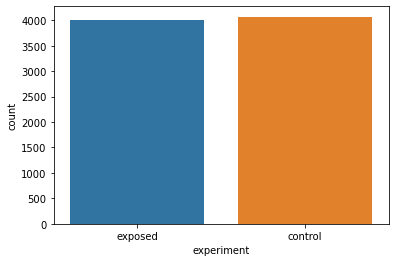

In [155]:
#plt.summary(exposed,control)
sb.countplot(df['experiment'])

<AxesSubplot:ylabel='value'>

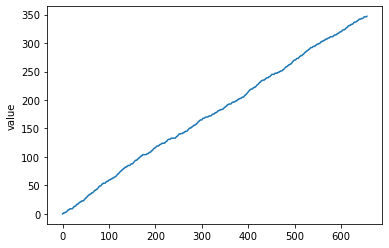

In [161]:
df_exp=pd.DataFrame(exposed)
a = df_exp.cumsum()
a.columns = ['value']
sb.lineplot(x = a.index, y = a.value)


<AxesSubplot:ylabel='value'>

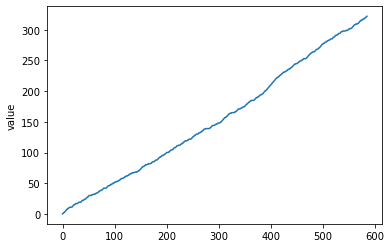

In [163]:
df_con=pd.DataFrame(control)
a = df_exp.cumsum()
a.columns = ['value']
sb.lineplot(x = a.index, y = a.value)


<ipython-input-87-02233628af8e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposed['date_hour'] = pd.to_datetime(exposed.date)
C:\Users\Smegn\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-87-02233628af8e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

Text(0.5, 0, 'cummulative success')

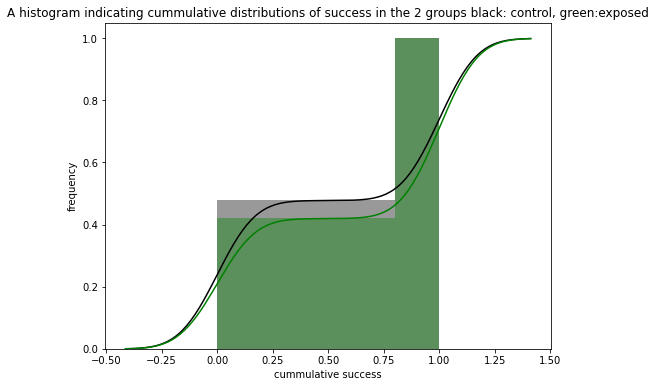

In [173]:
exposed,control=transform_data(df)
fig, ax = plt.subplots(figsize=(8,6))
kwargs = {'cumulative': True}
sb.distplot(exposed, hist_kws=kwargs, kde_kws=kwargs, color = 'black')
sb.distplot(control, hist_kws=kwargs, kde_kws=kwargs, color = 'green')
plt.title('A histogram indicating cummulative distributions of success in the 2 groups black: control, green:exposed')
plt.ylabel('frequency')
plt.xlabel('cummulative success')
 